In [1]:
#Determine whehter CESM2 daily tmax data is inconsistent with observations

In [1]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
#import daskdataframe as dd
import matplotlib.pyplot as plt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
%run data_handler.ipynb
import cartopy as cart

In [2]:
savefigs   = '/global/scratch/users/harsha/savefigs/Oct25/'
nclim_path = '/global/scratch/users/harsha/nclimgrid/'
era5_path = '/global/scratch/users/harsha/ERA5/tasmax/'
cesm2_path = '/global/scratch/users/harsha/LENS/cesm2/'
cvals      = '/global/scratch/users/harsha/LENS/cesm2/cvals/'
#CONUS lat-lon
top = 49.3457868 # north lat
left = -124.7844079 # west long
right = -66.9513812 # east long
bottom =  24.7433195 # south lat

In [3]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192'] 
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=20, walltime='10:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(8)

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34408 instead
  warnings.warn(


In [5]:
cluster

In [4]:
%%time
ds_temp = xr.open_mfdataset(cesm2_path+'lens_tmax.zarr',engine='zarr')
#ds_std  = xr.open_mfdataset(spaths,engine='zarr')

CPU times: user 3.3 s, sys: 702 ms, total: 4 s
Wall time: 17.8 s


In [5]:
%%time
####### ERA5 Data #########
era_temp  = xr.open_mfdataset(era5_path+'*.nc',concat_dim ='days',combine='nested')

CPU times: user 349 ms, sys: 167 ms, total: 516 ms
Wall time: 1.69 s


In [6]:
elats = era_temp['lats'].data
elons = era_temp['lons'].data

In [7]:
%%time 
########### GISTEMP v2.5- GHCNv4 ###########
gis_path = '/global/scratch/users/harsha/gistemp250_GHCNv4.zarr'
gistemp  = xr.open_mfdataset(gis_path,concat_dim='time',combine='nested',engine='zarr')

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/backends/api.py:996: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  datasets = [open_(p, **open_kwargs) for p in paths]


CPU times: user 550 ms, sys: 164 ms, total: 714 ms
Wall time: 6.44 s


In [8]:
gistemp

<xarray.Dataset>
Dimensions:      (lat: 90, lon: 180, time: 1711, nv: 2)
Coordinates:
  * lat          (lat) float32 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon          (lon) float32 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * time         (time) datetime64[ns] 1880-01-15 1880-02-15 ... 2022-07-15
Dimensions without coordinates: nv
Data variables:
    tempanomaly  (time, lat, lon) float32 dask.array<chunksize=(322, 90, 180), meta=np.ndarray>
    time_bnds    (time, nv) datetime64[ns] dask.array<chunksize=(1711, 2), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      Created 2022-08-10 10:02:36 by SBBX_to_nc 2.0 - ILAND=250, ...
    institution:  NASA Goddard Institute for Space Studies
    source:       http://data.giss.nasa.gov/gistemp/
    title:        GISTEMP Surface Temperature Analysis

In [9]:
%%time
gistemp_baseline = gistemp.tempanomaly.sel(time=slice('18800115','19041215')).mean('time') 
mgistemp         = gistemp.tempanomaly.sel(time=slice('19900115','20141215')).mean('time') 
gistemp_ano      = mgistemp -gistemp_baseline
#gistemp_ano.to_dataset.to_zarr(cvals+)

CPU times: user 115 ms, sys: 17.8 ms, total: 133 ms
Wall time: 231 ms


In [10]:
#gistemp_ano = gistemp_ano.to_array()
gistemp_ano

<xarray.DataArray 'tempanomaly' (lat: 90, lon: 180)>
dask.array<sub, shape=(90, 180), dtype=float32, chunksize=(90, 180), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float32 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0

In [ ]:
%%time
gistemp_cano = gistemp_ano.sel(lat=slice(bottom,top),lon=slice(left,right))
#gistemp_cano.to_dataset().to_zarr(cvals+'gistemp_cano1990_2014.zarr')

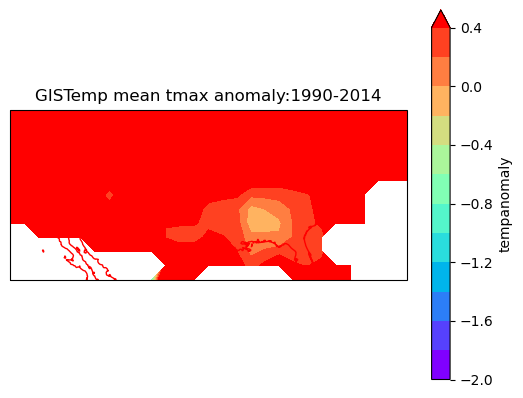

CPU times: user 2.46 s, sys: 307 ms, total: 2.77 s
Wall time: 5.08 s


In [13]:
%%time
gistemp_cano = xr.open_zarr(cvals+'gistemp_cano1990_2014.zarr')
ax       = plt.axes(projection=cart.crs.PlateCarree())
levs     = np.arange(-2,0.6,0.2)
gistemp_cano.tempanomaly.plot.contourf(ax=ax,cmap='rainbow',transform=cart.crs.PlateCarree(),levels =levs)
ax.coastlines(color="red")
plt.title('GISTemp mean tmax anomaly:1990-2014')
#plt.colorbar(cm.ScalarMappable(norm=, cmap='rainbow'))
plt.xlabel('lon')
plt.ylabel('lat')
plt.show()

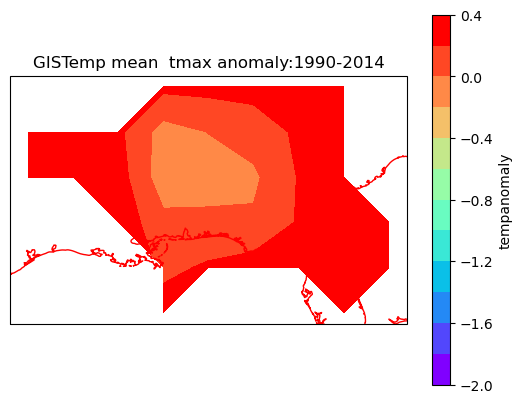

In [96]:
############ Mask gistemp anomaly above 0.4 K ######
gistemp_mcano = gistemp_cano.where(gistemp_cano<0.4)
ax       = plt.axes(projection=cart.crs.PlateCarree())
levs     = np.arange(-2,0.6,0.2)
gistemp_mcano.tempanomaly.plot.contourf(ax=ax,cmap='rainbow',transform=cart.crs.PlateCarree(),levels =levs)
ax.coastlines(color="red")
plt.title('GISTemp mean  tmax anomaly:1990-2014')
#plt.colorbar(cm.ScalarMappable(norm=, cmap='rainbow'))
plt.xlabel('lon')
plt.ylabel('lat')
plt.show()

In [97]:
gistemp_mcano

<xarray.Dataset>
Dimensions:      (lat: 13, lon: 29)
Coordinates:
  * lat          (lat) float32 25.0 27.0 29.0 31.0 33.0 ... 43.0 45.0 47.0 49.0
  * lon          (lon) float32 -123.0 -121.0 -119.0 -117.0 ... -71.0 -69.0 -67.0
Data variables:
    tempanomaly  (lat, lon) float32 dask.array<chunksize=(13, 29), meta=np.ndarray>

In [ ]:
############# USHCN monthly data ###########


In [56]:
%%time
#Check for global warming in CSEM2 model tasmax member = 0
dse0_nw  = ds_temp.sel(time =slice('18500101','18741231'),member=95).mean('time')
dse0_nw  = dse0_nw.sel(lat=elats,lon=elons,method='nearest')
dse0_w   = ds_temp.sel(time=slice('19900101','20141231'),member=95).mean('time')
dse0_w   = dse0_w.sel(lat=elats,lon=elons,method='nearest')
dsme0_w  = dse0_w.TREFHTMX
dsme0_nw = dse0_nw.TREFHTMX
anomalye0 = dsme0_w - dsme0_nw
#xr.align(dsme0_w,dsme0_nw,join='exact')
anomalye0 = anomalye0

CPU times: user 162 ms, sys: 11.2 ms, total: 173 ms
Wall time: 161 ms


In [72]:
### Get warming anomaly for each member and mask CONUS with positive anomaly
conus_nw  = ds_temp.sel(time =slice('18500101','18741231')).mean('time')
conus_nw  = conus_nw.sel(lat=elats,lon=elons,method='nearest')
conus_w   = ds_temp.sel(time=slice('19900101','20141231')).mean('time')
conus_w   = conus_w.sel(lat=elats,lon=elons,method='nearest')
conus_ma  = conus_w - conus_nw #ma = mean anomaly

In [89]:
%%time
conus_ma  = conus_ma.TREFHTMX.where(conus_ma<0.4)
#conus_ma  = conus_ma.to_array()
q95cma    = conus_ma.chunk(dict(member=-1)).quantile(0.95,dim='member')
q5cma     = conus_ma.chunk(dict(member=-1)).quantile(0.05,dim='member')

CPU times: user 116 ms, sys: 8.11 ms, total: 124 ms
Wall time: 115 ms


In [91]:
%%time
q95cma.to_zarr(cvals+'conus_coolano_95thp.zarr')
q5cma.to_zarr(cvals+'conus_coolano_05thp.zarr')

CPU times: user 2min 21s, sys: 7.39 s, total: 2min 28s
Wall time: 3min 13s


In [92]:
q5cma  = xr.open_zarr(cvals+'conus_coolano_05thp.zarr')
q95cma = xr.open_zarr(cvals+'conus_coolano_95thp.zarr')
q5cma  = q5cma.TREFHTMX
q95cma = q95cma.TREFHTMX

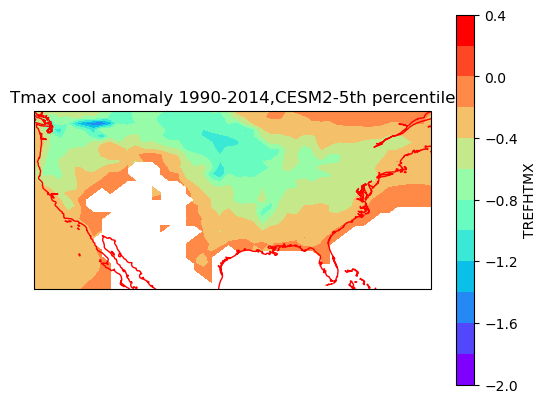

CPU times: user 4.09 s, sys: 324 ms, total: 4.41 s
Wall time: 4.14 s


In [93]:
%%time
levs = np.arange(-2,0.6,0.2)
ax     = plt.axes(projection=cart.crs.PlateCarree())
q5cma.plot.contourf(ax=ax,cmap='rainbow',transform=cart.crs.PlateCarree(),levels =levs)
ax.coastlines(color="red")
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('Tmax cool anomaly 1990-2014,CESM2-5th percentile')
#plt.savefig('gano_19902014_18501914_mem0.png')
plt.show()

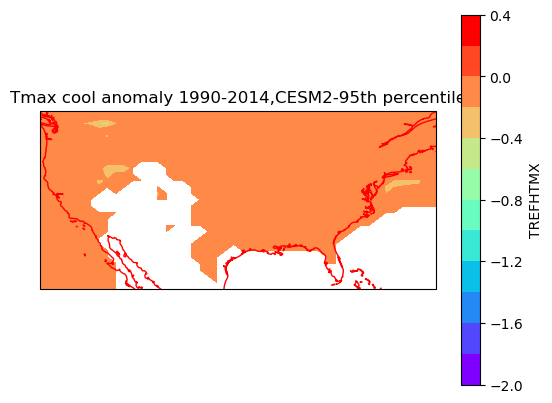

CPU times: user 3.62 s, sys: 301 ms, total: 3.92 s
Wall time: 3.85 s


In [95]:
%%time
levs = np.arange(-2,0.6,0.2)
ax     = plt.axes(projection=cart.crs.PlateCarree())
q95cma.plot.contourf(ax=ax,cmap='rainbow',transform=cart.crs.PlateCarree(),levels =levs)
ax.coastlines(color="red")
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('Tmax cool anomaly 1990-2014,CESM2-95th percentile')
#plt.savefig('gano_19902014_18501914_mem0.png')
plt.show()

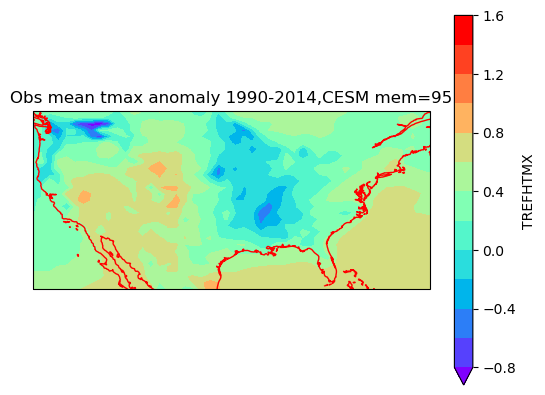

CPU times: user 11.5 s, sys: 675 ms, total: 12.2 s
Wall time: 16.9 s


In [58]:
%%time
levs = np.arange(-0.8,1.8,0.2)
ax     = plt.axes(projection=cart.crs.PlateCarree())
anomalye0.plot.contourf(ax=ax,cmap='rainbow',transform=cart.crs.PlateCarree(),levels =levs)
ax.coastlines(color="red")
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('Obs mean tmax anomaly 1990-2014,CESM mem=95')
#plt.savefig('gano_19902014_18501914_mem0.png')
plt.show()

In [ ]:
jan30_indcs = get_yearday_indcs(1990,2014,29) #Indices start from 0
#jan30_indcs

In [ ]:
%%time
eraj30 = era_temp.tasmax.sel(days=jan30_indcs)
#eraj30

In [ ]:
eraj30_mean = eraj30.mean('days')

In [ ]:
nclim = xr.open_mfdataset(nclim_path+'*.nc',concat_dim ='months',combine='nested')
nclim

In [ ]:
nclim_18951914 = nclim.tmax.sel(time=slice('18950101','19140101'))
nclim_mean     = nclim_18951914.mean('time')
#nclim_18951914
nclim_mean     = nclim_mean.assign_coords(lon=nclim_mean.lon+360)
nclim_mean     = nclim_mean.sel(months=0)

In [ ]:
dec30_indcs = get_yearday_indcs(1990,2014,364)
era_19902014 = era_temp.tasmax.sel(days=slice(1,dec30_indcs[-1]))
dec30_indcs[-1]

In [ ]:
era_mean = era_19902014.mean('days')
era_mean = era_mean.rename({'lats':'lat','lons':'lon'})
era_mean

In [ ]:
nclim_mean_eralike = nclim_mean.interp_like(era_mean)

In [ ]:
nclim_mean_eralike

In [ ]:
obs_ano = era_mean - nclim_mean_eralike-273.15

In [ ]:
obs_ano

CPU times: user 50.4 s, sys: 2.64 s, total: 53 s
Wall time: 1min 34s


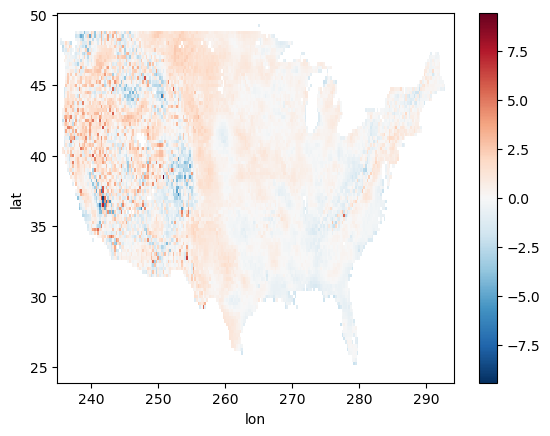

In [30]:
%%time
obs_ano.plot()

CPU times: user 20 µs, sys: 2 µs, total: 22 µs
Wall time: 42.2 µs


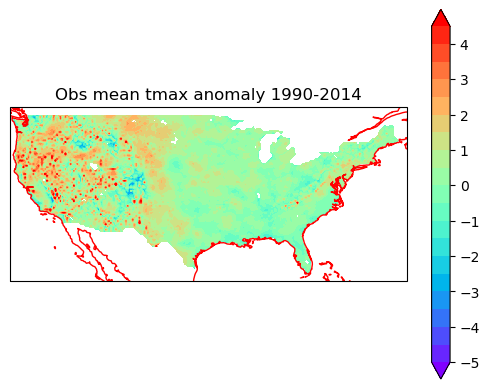

In [31]:
%time
ax   = plt.axes(projection=cart.crs.PlateCarree())
levs = np.arange(-5,5,0.5)
obs_ano.plot.contourf(ax=ax,cmap='rainbow',transform=cart.crs.PlateCarree(),levels =levs)
ax.coastlines(color="red")
plt.title('Obs mean tmax anomaly 1990-2014')
#plt.colorbar(cm.ScalarMappable(norm=, cmap='rainbow'))
plt.xlabel('lon')
plt.ylabel('lat')

plt.show()



In [32]:
#### 10 *10 lat lon grid on CONUS.
lats0 = np.linspace(24,49,10)
lons0 = np.linspace(235,294,10)

In [33]:
lats0

array([24.        , 26.77777778, 29.55555556, 32.33333333, 35.11111111,
       37.88888889, 40.66666667, 43.44444444, 46.22222222, 49.        ])

In [34]:
%time 
#red = reduced 
era_red    = era_19902014.sel(lats=lats0,lons=lons0,method='nearest')
era_mred   = era_red.mean('days')
era_mred   = era_mred.rename({'lats':'lat','lons':'lon'})
nclim_mred = nclim_mean.sel(lat=lats0,lon=lons0,method='nearest')
#Make sure lats and lons align perfectly
era_mred['lat']    = np.round(era_mred['lat'],2)
era_mred['lon']    = np.round(era_mred['lon'],2)
nclim_mred         = nclim_mred.assign_coords(lon=era_mred['lon'],lat=era_mred['lat'])
xr.align(era_mred, nclim_mred, join='exact')


CPU times: user 17 µs, sys: 1 µs, total: 18 µs
Wall time: 35 µs


(<xarray.DataArray 'tasmax' (lat: 10, lon: 10)>
 dask.array<copy, shape=(10, 10), dtype=float64, chunksize=(10, 10), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float64 24.0 26.75 29.5 32.25 35.0 38.0 40.75 43.5 46.25 49.0
   * lon      (lon) float64 235.0 241.5 248.0 254.8 ... 274.2 281.0 287.5 294.0,
 <xarray.DataArray 'tmax' (lat: 10, lon: 10)>
 dask.array<copy, shape=(10, 10), dtype=float32, chunksize=(10, 10), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float64 24.0 26.75 29.5 32.25 35.0 38.0 40.75 43.5 46.25 49.0
   * lon      (lon) float64 235.0 241.5 248.0 254.8 ... 274.2 281.0 287.5 294.0)

In [35]:
era_mred

<xarray.DataArray 'tasmax' (lat: 10, lon: 10)>
dask.array<mean_agg-aggregate, shape=(10, 10), dtype=float64, chunksize=(10, 10), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 24.0 26.75 29.5 32.25 35.0 38.0 40.75 43.5 46.25 49.0
  * lon      (lon) float64 235.0 241.5 248.0 254.8 ... 274.2 281.0 287.5 294.0

In [36]:
nclim_mred = nclim_mred.sel(months=0)
nclim_mred

KeyError: "'months' is not a valid dimension or coordinate"

In [ ]:
era_mred.plot()

In [ ]:
nclim_mred.plot()

In [ ]:
obs_ano_red = era_mred - nclim_mred -273.15
obs_ano_red

In [ ]:
obs_ano_red.plot()

In [ ]:
%time
ax = plt.axes(projection=cart.crs.PlateCarree())
ax.coastlines(color="red")
#plt.rcParams=300
obs_ano_red.plot.contourf(ax=ax,transform=cart.crs.PlateCarree(),cmap='coolwarm')
#plot = ax.contourf(era_mred['lon'],era_mred['lat'],obs_ano_red,transform=cart.crs.PlateCarree(),cmap='coolwarm')
#ax.stock_img()
plt.title('Obs mean tmax anomaly')
plt.colorbar(ax=ax)
ax.set_xlabel('lon')
ax.set_ylabel('lat')
plt.show()

In [ ]:
view_colormap('jet')